In [1]:
#Pandapower & other data processing stuff
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
# import pandapower.toolbox as tb
# import pandapower.timeseries as ts
# import pandapower.control as control
# from pandapower.control.controller.const_control import ConstControl
# from pandapower.timeseries.data_sources.frame_data import DFData
# from pandapower.timeseries.output_writer import OutputWriter
# from pandapower.timeseries.run_time_series import run_timeseries
# from pandapower.control.basic_controller import Controller
#  import simbench as sb

import matplotlib.pyplot as plt
import numpy as np
import random


# import stable_baselines3 as sb3


In [9]:
import grid_loader as gl
# grid_code = "1-HV-urban--0-sw"
# grid_code = "1-LV-urban6–0-sw"
# net = sb.get_simbench_net(grid_code)
net = gl.load_test_case_grid(39)

In [11]:
net.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,max_p_mw,min_p_mw
0,None,29,250.0,1.0499,NaN,140.0,400.0,1.0,False,True,0.0,None,True,1040.0,0.0
1,None,31,650.0,0.9841,NaN,150.0,300.0,1.0,False,True,0.0,None,True,725.0,0.0
2,None,32,632.0,0.9972,NaN,0.0,250.0,1.0,False,True,0.0,None,True,652.0,0.0
3,None,33,508.0,1.0123,NaN,0.0,167.0,1.0,False,True,0.0,None,True,508.0,0.0
4,None,34,650.0,1.0494,NaN,-100.0,300.0,1.0,False,True,0.0,None,True,687.0,0.0
5,None,35,560.0,1.0636,NaN,0.0,240.0,1.0,False,True,0.0,None,True,580.0,0.0
6,None,36,540.0,1.0275,NaN,0.0,250.0,1.0,False,True,0.0,None,True,564.0,0.0
7,None,37,830.0,1.0265,NaN,-150.0,300.0,1.0,False,True,0.0,None,True,865.0,0.0
8,None,38,1000.0,1.0300,NaN,-100.0,300.0,1.0,False,True,0.0,None,True,1100.0,0.0


Text(0, 0.5, '%')

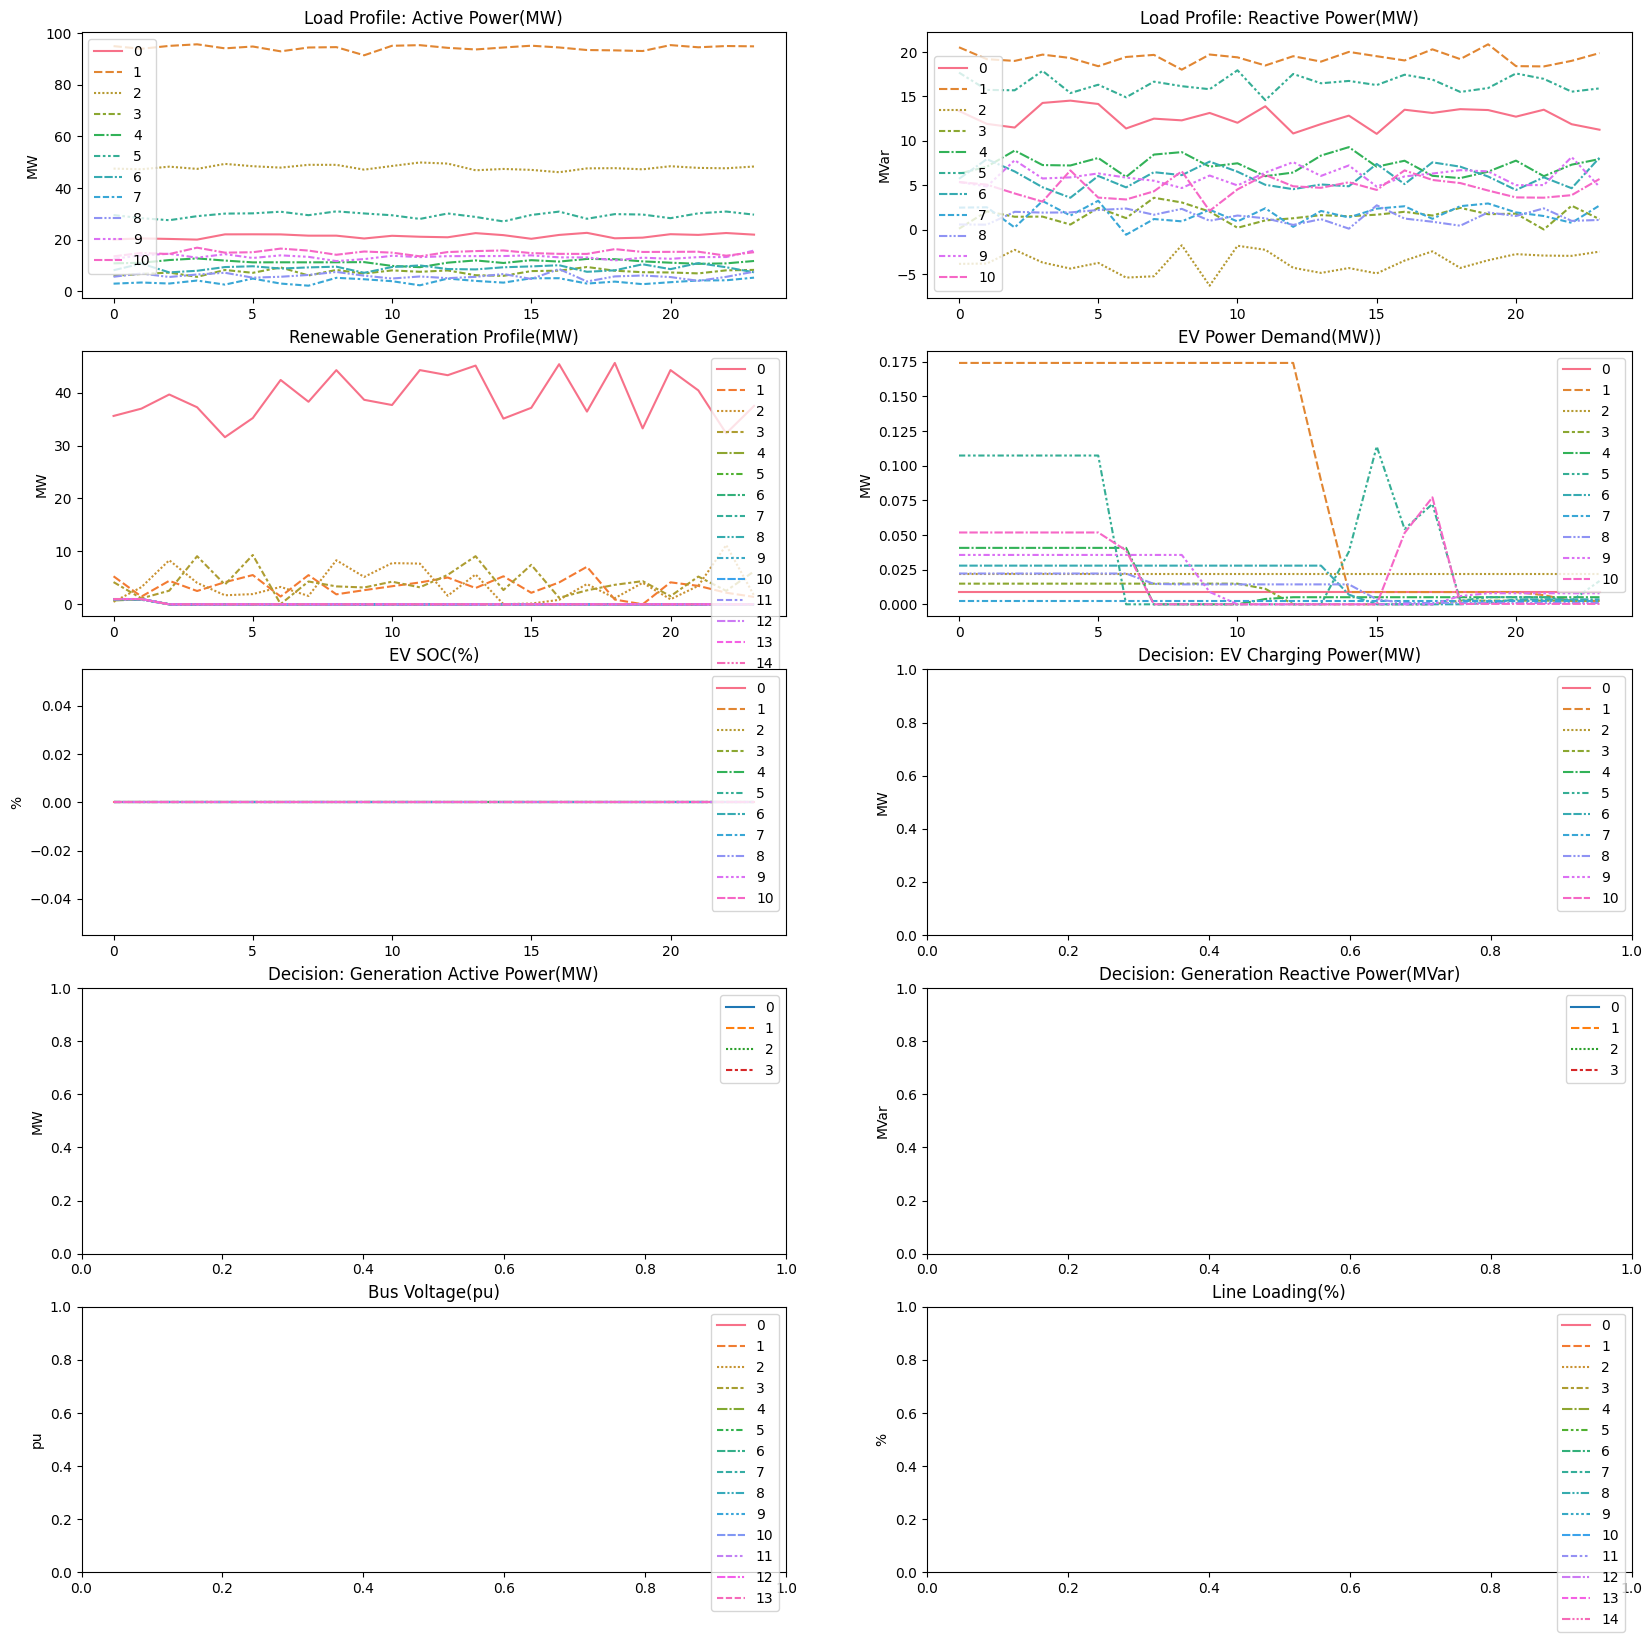

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df_load_p = pd.read_csv("../Evaluation/Case14_EV/load_p.csv")
df_load_q = pd.read_csv("../Evaluation/Case14_EV/load_q.csv")
df_renew = pd.read_csv("../Evaluation/Case14_EV/renewable.csv")
df_ev_demand = pd.read_csv("../Evaluation/Case14_EV/ev_demand.csv")
df_ev_soc = pd.read_csv("../Evaluation/Case14_EV/ev_soc.csv")
df_gen_p = pd.read_csv("../Evaluation/Case14_EV/gen_p.csv")
df_gen_q = pd.read_csv("../Evaluation/Case14_EV/gen_q.csv")
df_ev_action = pd.read_csv("../Evaluation/Case14_EV/ev_action.csv")
df_voltage = pd.read_csv("../Evaluation/Case14_EV/voltage.csv")
df_line_loading = pd.read_csv("../Evaluation/Case14_EV/line_loading.csv")

#define plotting region (5 rows, 5 columns)
fig, axes = plt.subplots(5, 2,figsize=(20,20))
sns.lineplot(data=df_load_p, ax=axes[0,0])
sns.lineplot(data=df_load_q, ax=axes[0,1])
sns.lineplot(data=df_renew, ax=axes[1,0])
sns.lineplot(data=df_ev_demand, ax=axes[1,1])
sns.lineplot(data=df_ev_soc, ax=axes[2,0])
sns.lineplot(data=df_ev_action, ax=axes[2,1])
sns.lineplot(data=df_gen_p, ax=axes[3,0])
sns.lineplot(data=df_gen_p, ax=axes[3,1])
sns.lineplot(data=df_voltage, ax=axes[4,0])
sns.lineplot(data=df_line_loading, ax=axes[4,1])

axes[0,0].set_title("Load Profile: Active Power(MW)")
axes[0,1].set_title("Load Profile: Reactive Power(MW)")
axes[1,0].set_title("Renewable Generation Profile(MW)")
axes[1,1].set_title("EV Power Demand(MW))")
axes[2,0].set_title("EV SOC(%)")
axes[2,1].set_title("Decision: EV Charging Power(MW)")
axes[3,0].set_title("Decision: Generation Active Power(MW)")
axes[3,1].set_title("Decision: Generation Reactive Power(MVar)")
axes[4,0].set_title("Bus Voltage(pu)")
axes[4,1].set_title("Line Loading(%)")


# axes.set_xlabel("Hour")
axes[0,0].set_ylabel("MW")
axes[0,1].set_ylabel("MVar")
axes[1,0].set_ylabel("MW")
axes[1,1].set_ylabel("MW")
axes[2,0].set_ylabel("%")
axes[2,1].set_ylabel("MW")
axes[3,0].set_ylabel("MW")
axes[3,1].set_ylabel("MVar")
axes[4,0].set_ylabel("pu")
axes[4,1].set_ylabel("%")

In [25]:
df = pd.read_csv("../Data/German_EV/emobpy_timeseries_hourly.csv")
df.head()

/var/folders/w4/7lpv40nd2g79_r3by73bjd7c0000gn/T/ipykernel_795/2004322136.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/German_EV/emobpy_timeseries_hourly.csv")


,Unnamed: 0,ID,VehicleMobility,DrivingConsumption,GridAvailability,GridDemand_Immediate_full_capacity,GridDemand_Immediate_full_capacity.1,GridDemand_Immediate_balanced,GridDemand_Immediate_balanced.1,GridDemand_From_0_to_24_at_home,GridDemand_From_0_to_24_at_home.1,GridDemand_From_23_to_8_at_home,GridDemand_From_23_to_8_at_home.1
0,NaN,ID,Distance_km,Consumption_kWh,PowerRating_kW,Load_kW,SoC,Load_kW,SoC,Load_kW,SoC,Load_kW,SoC
1,date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 00:00:00,0.0,0.0,0.0,3.7,3.7,0.546,0.426,0.50525,0.426,0.50525,0.426,0.50525
3,2020-01-01 01:00:00,0.0,0.0,0.0,3.7,3.7,0.62,0.426,0.514,0.426,0.514,0.426,0.514
4,2020-01-01 02:00:00,0.0,0.0,0.0,3.7,3.7,0.694,0.426,0.5222500000000001,0.426,0.5222500000000001,0.426,0.5222500000000001


In [26]:
# df = pd.read_csv("../Data/German_EV/emobpy_timeseries_original.csv")
# Modify column names by appending the content of the first row
new_column_names = [f"{col}_{df.at[0, col]}" for col in df.columns]

# Assign the new column names to the DataFrame
df.columns = new_column_names

# Drop the first and second rows
df = df.drop([0, 1]).reset_index(drop=True)

# Define a conversion function to convert values into float or int
def convert_to_float_int(value):
    try:
        # Try to convert to float
        float_val = float(value)
        # If the float value is equivalent to an int, return as int
        if float_val.is_integer():
            return int(float_val)
        else:
            return float_val
    except ValueError:
        # Return the original value if conversion fails
        return value

# Apply the conversion function to each element in the DataFrame
df = df.map(convert_to_float_int)
df = df.rename(columns={"Unnamed: 0_nan":"Time", 
                        "ID_ID":"ID",
                        "VehicleMobility_Location":"Location",
                        "VehicleMobility.1_Distance_km":"Distance_km", 
                        "DrivingConsumption_Consumption_kWh":"DrivingConsumption_kWh",
                        "GridAvailability_ChargingStation":"ChargingStation",
                        "GridAvailability.1_PowerRating_kW":"ChargingAvailability_kW",
                        "GridDemand_Immediate_full_capacity_Load_kW":"ChargingPowerImmediateFull_kW",
                        "GridDemand_Immediate_full_capacity.1_SoC":"SOCImmediateFull",
                        "GridDemand_Immediate_balanced_Load_kW":"ChargingPowerImmediateBalanced_kW",
                        "GridDemand_Immediate_balanced.1_SoC":"SOCImmediateBalanced",
                        "GridDemand_From_0_to_24_at_home_Load_kW":"ChargingPowerHome_kW",
                        "GridDemand_From_0_to_24_at_home.1_SoC":"SOCHome",
                        "GridDemand_From_23_to_8_at_home_Load_kW":"ChargingPowerNight_kW",
                        "GridDemand_From_23_to_8_at_home.1_SoC":"SOCNight"})
# df = df[df["ID"] < net.load.index.size]
df = df[df["ID"] < 11]
df['Time'] = pd.to_datetime(df['Time'])
df["Time_step"] = (df['Time'].astype('int64') - df['Time'].astype('int64').min()) // (3600 * 10**9)

NameError: name 'net' is not defined

In [ ]:
df_multiIndexed = df.set_index(['ID', 'Time_step'])
df_multiIndexed

Time  VehicleMobility_Distance_km  \
ID Time_step                                                    
0  0         2020-01-01 00:00:00                          0.0   
   1         2020-01-01 01:00:00                          0.0   
   2         2020-01-01 02:00:00                          0.0   
   3         2020-01-01 03:00:00                          0.0   
   4         2020-01-01 04:00:00                          0.0   
...                          ...                          ...   
10 8755      2020-12-30 19:00:00                          0.0   
   8756      2020-12-30 20:00:00                          0.0   
   8757      2020-12-30 21:00:00                          0.0   
   8758      2020-12-30 22:00:00                          0.0   
   8759      2020-12-30 23:00:00                          0.0   

              DrivingConsumption_kWh  GridAvailability_PowerRating_kW  \
ID Time_step                                                            
0  0                             0.0                              3.7   
   1                             0.0                              3.7   
   2                             0.0                              3.7   
   3                             0.0                              3.7   
   4                             0.0                              3.7   
...                              ...                              ...   
10 8755                          0.0                              3.7   
   8756                          0.0                              3.7   
   8757                          0.0                              3.7   
   8758                          0.0                              3.7   
   8759                          0.0                              3.7   

              ChargingPowerImmediateFull_kW  SOCImmediateFull  \
ID Time_step                                                    
0  0                                    3.7             0.546   
   1                                    3.7             0.620   
   2                                    3.7             0.694   
   3                                    3.7             0.768   
   4                                    3.7             0.842   
...                                     ...               ...   
10 8755                                 0.0             1.000   
   8756                                 0.0             1.000   
   8757                                 0.0             1.000   
   8758                                 0.0             1.000   
   8759                                 0.0             1.000   

              ChargingPowerImmediateBalanced_kW  SOCImmediateBalanced  \
ID Time_step                                                            
0  0                                      0.426               0.50525   
   1                                      0.426               0.51400   
   2                                      0.426               0.52225   
   3                                      0.426               0.53100   
   4                                      0.426               0.53925   
...                                         ...                   ...   
10 8755                                   0.867               0.92525   
   8756                                   0.867               0.94225   
   8757                                   0.867               0.95950   
   8758                                   0.867               0.97650   
   8759                                   0.867               0.99350   

              ChargingPowerHome_kW  SOCHome  ChargingPowerNight_kW  SOCNight  
ID Time_step                                                                  
0  0                         0.426  0.50525                  0.426   0.50525  
   1                         0.426  0.51400                  0.426   0.51400  
   2                         0.426  0.52225                  0.426   0.52225  
   3                         0.426  0.531

In [32]:
max_EV_demand = df_multiIndexed.loc[df_multiIndexed.groupby(level=0).idxmax()] / 1000

NameError: name 'df_multiIndexed' is not defined

In [29]:
def select_randomly_day_EV_profile():
    # randomly select the EV profile from the df_EV
    selected_day = random.randint(0, 364) * 24
    return df_multiIndexed.loc[(slice(None), selected_day), "SOCImmediateBalanced"].to_numpy()

print(select_randomly_day_EV_profile())

[0.99175 0.9875  0.9315  0.9705  0.89325 0.981   0.90625 0.975   0.9895
 0.92125 0.981  ]


In [31]:
import pandapower.networks as pn
n = 14
case = f"case{n}" # n: case number in pandapower 
net = getattr(pn, case)()


AttributeError: partially initialized module 'pandapower' has no attribute 'auxiliary' (most likely due to a circular import)

In [19]:

# add the EV element to the grid
def add_EV_storage(grid):
    # number of loads
    NL = len(grid.load["bus"])
    total_EV = NL * 10 # total number of EVs is assumed to be 10 times the number of loads
    EV_ID= []

    # randomly extract EV ID list range from 0 to 199
    for i in range(total_EV):
        EV_ID.append(random.randint(0,199))

    # assign the EV(ID) to the loads depending on the nominal power of the loads. If there are EV(ID) left, assign them to the loads with the highest nominal power
    load_sum = grid.load.loc[:, 'p_mw'].sum()
    grid.load['EV_ID'] = [[] for _ in grid.load.index]  # Initialize each cell with an empty list
    for i in grid.load.index:
        bus = grid.load.loc[i, 'bus']
        weight = grid.load.loc[i, 'p_mw']/load_sum
        n_EV_bus = int(weight * total_EV) # number of EVs connected to the bus 

        for _ in range(n_EV_bus):
            if EV_ID:  # Check if there are still EV_IDs available
                grid.load.loc[i, 'EV_ID'].append(EV_ID.pop(0))  # Assign and remove the first available EV_ID
            else:
                break  # No more EV_IDs to assign
      

# assign the remaining EV_IDs to the loads with the highest nominal power
    max_load = grid.load['p_mw'].idxmax()
    if EV_ID:
        print(len(grid.load.loc[max_load, 'EV_ID']))
        grid.load.loc[max_load, 'EV_ID'].extend(EV_ID)
        print(len(grid.load.loc[max_load, 'EV_ID']))



add_EV_storage(net)

40
45


In [3]:
header = pd.read_csv("../Data/German_EV/emobpy_input_data.csv", nrows=1)  # Read only the header
cols_to_use = header.columns[4:]  # Skip the first 4 columns
print(cols_to_use)

Index(['Level_3', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '190', '191', '192', '193', '194', '195', '196', '197', '198', '199'],
      dtype='object', length=201)


In [ ]:
time_step = self.dispatching_intervals - self.episode_length
energy_requirement = self.df_EV.loc[(i, time_step), "ChargingPowerImmediateBalanced_kW"] / 1000 # power requirement per car in MW
energy_requirement * self.net.storage.loc[i, "n_car"] 

In [4]:
# header = pd.read_csv("../Data/German_EV/emobpy_input_data.csv", nrows=1)  # Read only the header
# cols_to_use = header.columns[4:]  # Skip the first 4 columns
rows_to_read = [0, 1069, 1070, 1071]  # Adjust for 0-based indexing, considering the header as row 0
# df_EV_capacity = pd.concat([pd.read_csv("../Data/German_EV/emobpy_input_data.csv", skiprows=lambda x: x not in rows_to_read and x != 0, header=0),
                                            # pd.read_csv("../Data/German_EV/emobpy_input_data.csv", skiprows=lambda x: x < 1071, nrows=0)])
df_EV_capacity = pd.read_csv("../Data/German_EV/emobpy_input_data.csv", skiprows=lambda x: x not in rows_to_read and x != 0, header=0)
df_EV_capacity.drop(columns = df_EV_capacity.columns[0:4], inplace=True)
df_EV_capacity = df_EV_capacity.rename(columns = {"Level_3": "Parameter"})
# df_EV_capacity.set_index("Parameter", inplace=True)

In [33]:
df_EV_capacity

,Parameter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,Battery capacity kWh (kilowatt hours),45.00,45.00,45.61,45.00,79.50,45.00,79.50,45.61,79.50,45.61,45.61,64.00,45.61,64.00,45.61,45.00,64.00,45.00,45.00,45.00,64.00,64.00,45.61,79.50,79.50,45.61,79.50,79.50,45.61,45.61,45.00,64.00,45.61,64.00,64.00,79.50,45.00,79.50,64.00,45.00,45.61,64.00,79.50,45.00,79.50,45.00,64.00,45.00,45.61,79.50,64.00,79.50,45.00,79.50,79.50,64.00,79.50,45.00,79.50,79.50,45.61,45.00,45.00,64.00,45.61,45.00,79.50,45.00,64.00,79.50,64.00,45.00,45.61,45.00,45.61,45.61,45.61,45.00,45.00,45.00,79.50,45.00,45.61,64.00,64.00,45.61,79.50,79.50,45.00,45.61,79.50,64.00,45.00,64.00,79.50,79.50,45.61,45.61,45.61,45.00,64.00,45.61,64.00,79.50,79.50,79.50,45.61,64.00,64.00,45.61,64.00,45.61,79.50,64.00,79.50,45.00,79.50,45.00,79.50,45.61,45.61,64.00,64.00,64.00,45.61,79.50,45.61,45.61,79.50,45.00,45.00,45.00,45.00,64.00,64.00,79.50,64.00,64.00,79.50,45.00,64.00,45.00,64.00,45.61,64.00,45.61,45.00,45.00,64.00,64.00,79.50,45.61,45.61,79.50,64.00,64.00,79.50,64.00,79.50,45.00,79.50,45.61,45.00,45.00,64.00,64.00,79.50,64.00,45.00,45.61,64.00,45.61,45.00,45.00,45.00,79.50,45.61,64.00,45.00,45.61,45.00,45.61,45.61,79.50,79.50,79.50,45.61,45.61,64.00,79.50,79.50,64.00,45.00,45.61,45.00,45.61,79.50,45.61,64.00,64.00
1,Battery_charging_efficiency,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90,0.90
2,Battery_discharging_efficiency,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0

In [27]:
import pandapower as pp
for i in net.load.index:
    bus = net.load.loc[i, "bus"]
    n_car = net.load.loc[i, "p_mw"] * 10
    pp.create_storage(net, bus=bus, p_mw=0, max_e_mwh= df_EV_capacity[str(i)]*n_car / 1000, soc_percent=0, min_e_mwh=0, evid = i)

AttributeError: partially initialized module 'pandapower' has no attribute 'auxiliary' (most likely due to a circular import)

In [46]:
net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,evid
0,None,1,0.0,0.0,NaN,0.0,0.0,9.76500,1.0,True,None,0.0
1,None,2,0.0,0.0,NaN,0.0,0.0,42.39000,1.0,True,None,1.0
2,None,3,0.0,0.0,NaN,0.0,0.0,21.80158,1.0,True,None,2.0
3,None,4,0.0,0.0,NaN,0.0,0.0,3.42000,1.0,True,None,3.0
4,None,5,0.0,0.0,NaN,0.0,0.0,8.90400,1.0,True,None,4.0
5,None,8,0.0,0.0,NaN,0.0,0.0,13.27500,1.0,True,None,5.0
6,None,9,0.0,0.0,NaN,0.0,0.0,7.15500,1.0,True,None,6.0
7,None,10,0.0,0.0,NaN,0.0,0.0,1.59635,1.0,True,None,7.0
8,None,11,0.0,0.0,NaN,0.0,0.0,4.84950,1.0,True,None,8.0
9,None,12,0.0,0.0,NaN,0.0,0.0,6.15735,1.0,True,None,9.0


In [2]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
0,None,0,51.0,27.0,0.0,0.0,NaN,1.0,True,None,False
1,None,1,20.0,9.0,0.0,0.0,NaN,1.0,True,None,False
2,None,2,39.0,10.0,0.0,0.0,NaN,1.0,True,None,False
3,None,3,39.0,12.0,0.0,0.0,NaN,1.0,True,None,False
4,None,5,52.0,22.0,0.0,0.0,NaN,1.0,True,None,False
5,None,6,19.0,2.0,0.0,0.0,NaN,1.0,True,None,False
6,None,7,28.0,0.0,0.0,0.0,NaN,1.0,True,None,False
7,None,10,70.0,23.0,0.0,0.0,NaN,1.0,True,None,False
8,None,11,47.0,10.0,0.0,0.0,NaN,1.0,True,None,False
9,None,12,34.0,16.0,0.0,0.0,NaN,1.0,True,None,False


In [17]:
load_pmw = profiles[('load', 'p_mw')]
load_qvar = profiles[('load', 'q_mvar')]

In [10]:
profiles[('sgen','p_mw')].shape

(35136, 98)

In [9]:
profiles[('gen','p_mw')].shape

(35136, 0)

In [24]:
state = np.concatenate((load_pmw_profile[0], load_qvar_profile[0]), axis=None)
state.shape

(158,)

In [4]:
def convertTuple(tup):
    str = '_'.join(tup)
    return str
for i in profiles.keys():
    a = convertTuple(i)
    if a == 'load_p_mw':
        load_pmw = profiles[i]
    elif a == 'load_q_mvar':
        load_qmvar = profiles[i]

In [145]:
# open the grid and modify it
net = pn.example_simple()
net.gen.drop(net.gen.index, inplace=True)
pp.create_sgen(net, 5, p_mw=1)
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,static generator,6,2.0,-0.5,NaN,1.0,True,wye,True
1,None,5,1.0,0.0,NaN,1.0,True,wye,True


In [12]:
net = pn.case14()
net.line.index.size

15

In [11]:
net = pn.example_simple()
net.line.index.size

4

In [18]:
df = pd.read_json("/Users/YANG_Chialing/Desktop/Master_Thesis_TUM/pandapower/tutorials/cigre_timeseries_15min.json")
ds = DFData(df)


In [32]:
import random

In [39]:
time_steps

96

In [54]:
time_steps = df['residential'].size
a = df.loc[random.randint(0, time_steps):, 'residential'].to_numpy()
a

array([0.57492333, 0.63139   , 0.695165  , 0.72372   , 0.776485  ,
       0.81294   , 0.85957857, 0.86886   , 0.902426  , 0.9147775 ,
       0.9045125 , 0.884404  , 0.82973333, 0.82093286, 0.79572333,
       0.738732  , 0.70009   , 0.68904333, 0.67773   , 0.64621   ,
       0.613804  , 0.54032667, 0.49903714, 0.46920857, 0.43566   ,
       0.41087   , 0.344715  , 0.304026  , 0.28632818])

In [55]:
b = [a[(len(a)-1)], 0]
b

[0.2863281818, 0]

In [56]:
np.full((2, ), 1)

array([1, 1])

In [19]:
df

,timestep,pv,wind,residential
0,0,0.006143,0.622600,0.256022
1,1,0.005877,0.623585,0.248835
2,2,0.005505,0.625056,0.211973
3,3,0.005293,0.625897,0.201825
4,4,0.004921,0.627369,0.209164
5,5,0.004619,0.645138,0.198600
6,6,0.004286,0.685128,0.189050
7,7,0.003929,0.713267,0.186924
8,8,0.003674,0.719497,0.187007
9,9,0.003392,0.686113,0.183658


In [14]:
import json
with open("/Users/YANG_Chialing/Desktop/Master_Thesis_TUM/pandapower/tutorials/cigre_timeseries_15min.json") as json_file:
            profile = json.load(json_file)


dict_keys(['timestep', 'pv', 'wind', 'residential'])

In [16]:
profile['pv'].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95'])

/Users/YANG_Chialing/Desktop/Master_Thesis_TUM/new_venv/lib/python3.12/site-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 48)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/Users/YANG_Chialing/Desktop/Master_Thesis_TUM/new_venv/lib/python3.12/site-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 48/48 [00:00<00:00, 60.75it/s]


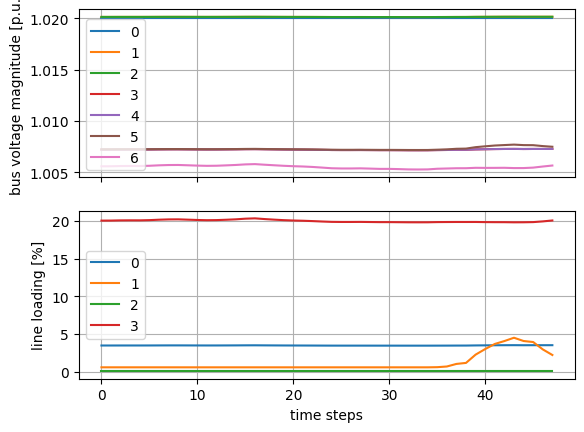

In [10]:
# add controller for sgens and loads
ConstControl(net, "sgen", "p_mw", element_index=net.sgen.index, profile_name=["wind", "pv"], data_source=ds)
ConstControl(net, "load", "p_mw", element_index=net.load.index, profile_name=["residential"], data_source=ds)

# add the output writer to store results
ow = OutputWriter(net, time_steps=(0, 95), output_path="./results/", output_file_type=".xlsx")
# these values are logged by default anyway and must not be explicitly set
# ow.log_variable("res_bus", "vm_pu")
# ow.log_variable("res_line", "loading_percent")

# run the time series
run_timeseries(net, time_steps=range(0, 48))

# optional: plot the result
fig, axes = plt.subplots(2, 1, sharex=True)
df = pd.read_excel("./results/res_bus/vm_pu.xlsx", index_col=0)
df.plot(ax=axes[0])
axes[0].set_ylabel("bus voltage magnitude [p.u.]")
df = pd.read_excel("./results/res_line/loading_percent.xlsx", index_col=0)
df.plot(ax=axes[1])
axes[1].set_ylabel("line loading [%]")
[ax.grid() for ax in axes]
plt.xlabel("time steps")
plt.show()

In [ ]:
#for plotting
#import pandapower.plotting as pplot
#import matplotlib.pyplot as plt
#import seaborn as sns


In [3]:
#Pandapower PF solver
pp.runpp(net,algorithm = 'gs')

In [4]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,159.488889,66.972650,-154.257847,-56.580041,5.231041,10.392609,0.697903,0.706412,0.706412,1.060000,0.000000,0.994726,-4.395755,1.668466
1,75.845098,34.312702,-72.417894,-25.166748,3.427205,9.145953,0.335862,0.343773,0.343773,1.060000,0.000000,0.953759,-8.482768,0.811952
2,72.867943,23.436889,-70.035050,-15.518439,2.832893,7.918450,0.329090,0.333817,0.333817,0.994726,-4.395755,0.919011,-12.712227,0.788438
3,57.227284,11.238733,-55.205925,-8.299525,2.021358,2.939208,0.250739,0.253161,0.253161,0.994726,-4.395755,0.943078,-10.109417,0.597938
4,42.462621,9.204419,-41.356268,-9.112003,1.106353,0.092416,0.186801,0.189890,0.189890,0.994726,-4.395755,0.953759,-8.482768,0.448498
5,-24.164950,-3.481561,24.635120,3.571834,0.470170,0.090273,0.113614,0.112883,0.113614,0.919011,-12.712227,0.943078,-10.109417,0.268344
6,-61.739528,-3.488168,62.313509,5.298678,0.573980,1.810510,0.280423,0.280423,0.280423,0.943078,-10.109417,0.953759,-8.482768,0.662327
7,7.171360,3.572149,-7.105482,-3.434193,0.065878,0.137956,23.116897,23.116897,23.116897,0.962001,-14.929670,0.947603,-15.612953,0.084124
8,7.784960,2.548566,-7.695843,-2.363087,0.089118,0.185479,23.635471,23.635471,23.635471,0.962001,-14.929670,0.945439,-15.986947,0.086011
9,17.704334,7.325710,-17.441928,-6.808950,0.262406,0.516760,55.283844,55.283844,55.283844,0.962001,-14.929670,0.940098,-16.083898,0.201181


In [ ]:
#OPF solver
pp.runopp(net, verbose=True)

In [ ]:
tb.lf_info(net)

In [9]:
#show voltage-violated bus
max_v = net.bus.max_vm_pu
min_v = net.bus.min_vm_pu
tb.violated_buses(net, min_v, max_v) #max voltage is 1.06 pu, min voltage is 0.94 pu


Index([5, 6, 7], dtype='int64')

In [ ]:
#show overloaded_lines
tb.overloaded_lines(net, 100).size #maximum load is 100%

0

In [ ]:
#simple plotting
from pandapower.plotting import simple_plotly
simple_plotly(net)

/Users/YANG_Chialing/Desktop/Master_Thesis_TUM/new_venv/lib/python3.12/site-packages/pandapower/networks/mv_oberrhein.py:75: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2, -3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

The number of given colors (1) is smaller than the number of nodes (179) to draw! The colors will be repeated to fit.


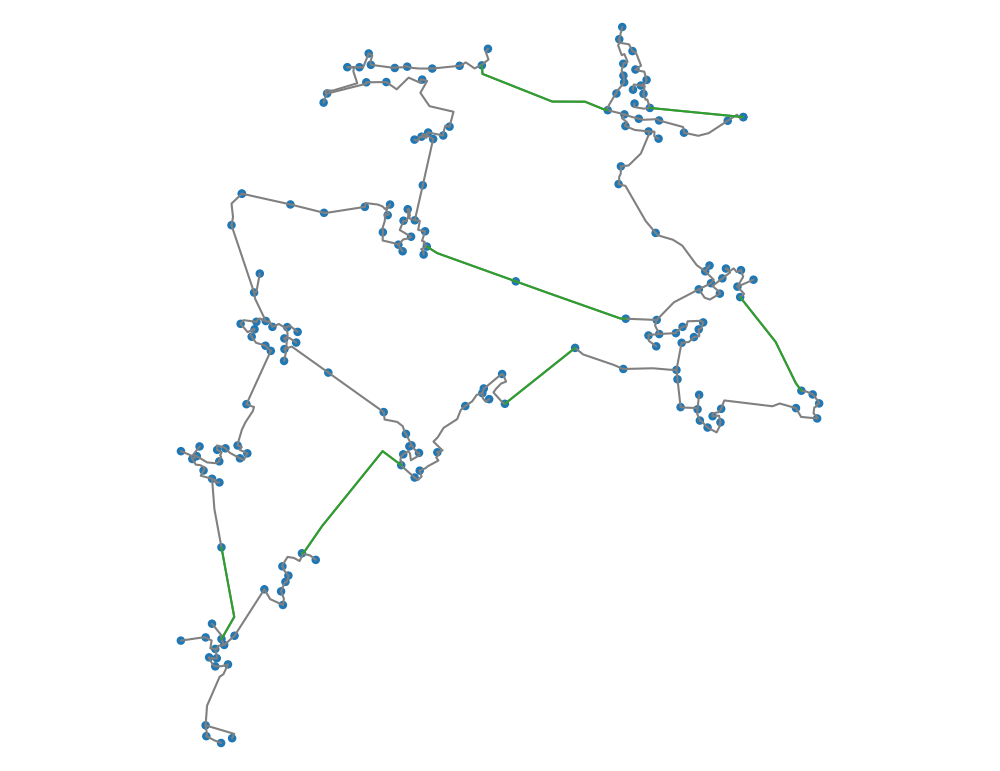

In [ ]:
#advanced plotting
colors = sns.color_palette()

net = nw.mv_oberrhein()
bc = pplot.create_bus_collection(net, buses=net.bus.index, color=colors[0], size=80, zorder=1)
lc = pplot.create_line_collection(net, lines=net.line.index, color='grey', zorder=2)

long_lines = net.line.loc[net.line.length_km > 2.].index
lcl = pplot.create_line_collection(net, lines=long_lines, color=colors[2], zorder=2)
pplot.draw_collections([lc, bc, lcl])
plt.show()

In [ ]:
#OPF solver
#pp.runopp(net, verbose=True)